<a href="https://colab.research.google.com/github/mwojcik01/CNN/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#kopiowanie
import os
import numpy as np
import shutil

#przygotowanie modelu
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras import layers
from keras import optimizers
from tensorflow.keras import optimizers
#from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

#wykres
import pandas as pd
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!unzip -uq "/content/drive/My Drive/base_ddsm_cbm_2.zip" -d "./" # wypakowanie plików z Drive

In [4]:
base_dir = './base_ddsm_cbm_2' # obliczanie ilości plików w każdym folderze
raw_no_of_files = {}
classes = ['ben_mal', 'nor']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('ben_mal', 2003), ('nor', 9215)])

In [5]:
#kasowanie plików
%%bash
pwd
rm -R images
ls

/content
base_ddsm_cbm_2
drive
sample_data


rm: cannot remove 'images': No such file or directory


In [6]:
data_dir = './images' # tworzenie katalogów: treningowego, walidacyjnego oraz testowego. 
                      #w każdym znajdują się 2 foldery: nor, ben_mal

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_nor_dir = os.path.join(train_dir, 'nor')
train_ben_mal_dir = os.path.join(train_dir, 'ben_mal')

valid_nor_dir = os.path.join(valid_dir, 'nor')
valid_ben_mal_dir = os.path.join(valid_dir, 'ben_mal')

test_nor_dir = os.path.join(test_dir, 'nor')
test_ben_mal_dir = os.path.join(test_dir, 'ben_mal')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_nor_dir, train_ben_mal_dir, valid_nor_dir, valid_ben_mal_dir, test_nor_dir, test_ben_mal_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [7]:
#kopiowanie
nor_fnames = os.listdir(os.path.join(base_dir, 'nor'))
ben_mal_fnames = os.listdir(os.path.join(base_dir, 'ben_mal'))


nor_fnames = [fname for fname in nor_fnames if fname.split('.')[1].lower() in ['png']]
ben_mal_fnames = [fname for fname in ben_mal_fnames if fname.split('.')[1].lower() in ['png']]

In [8]:
size = min(len(nor_fnames), len(ben_mal_fnames)) # ustalanie ilości plików w folderze 

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [9]:
for i, fname in enumerate(nor_fnames): # proces kopiowania plików
    if i <= train_idx:
        src = os.path.join(base_dir, 'nor', fname)
        dst = os.path.join(train_nor_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'nor', fname)
        dst = os.path.join(valid_nor_dir, fname)
        shutil.copyfile(src, dst) 
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'nor', fname)
        dst = os.path.join(test_nor_dir, fname)
        shutil.copyfile(src, dst) 

for i, fname in enumerate(ben_mal_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'ben_mal', fname)
        dst = os.path.join(train_ben_mal_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'ben_mal', fname)
        dst = os.path.join(valid_ben_mal_dir, fname)
        shutil.copyfile(src, dst) 
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'ben_mal', fname)
        dst = os.path.join(test_ben_mal_dir, fname)
        shutil.copyfile(src, dst)

In [10]:
# sprawdzanie ilości plików w folderach
print('nor - trening', len(os.listdir(train_nor_dir))) 
print('nor - walidacja', len(os.listdir(valid_nor_dir)))
print('nor - test', len(os.listdir(test_nor_dir)))

print('ben_mal - trening', len(os.listdir(train_ben_mal_dir)))
print('ben_mal - walidacja', len(os.listdir(valid_ben_mal_dir)))
print('ben_mal - test', len(os.listdir(test_ben_mal_dir)))

nor - trening 1403
nor - walidacja 400
nor - test 200
ben_mal - trening 1403
ben_mal - walidacja 400
ben_mal - test 200


In [11]:
Image_Width=128
Image_Height=128
Image_Channels=3
train_it_batch_size=50
test_it_batch_size=20
val_it_batch_size=20
train_it_photos_amount=3000
test_it_photos_amount=200
val_it_photos_amount=1000

In [12]:
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
	Flatten,Dense
from sklearn.metrics import roc_curve, auc

In [13]:
def create_graphs(history):

	plt.subplot(211)
	plt.title('Funkcja straty')
	plt.plot(history.history['loss'], color='blue', label='treningowe')
	plt.plot(history.history['val_loss'], color='red', label='testujące')
	plt.legend()
	plt.xlabel("epoki")
	plt.ylabel("wartość straty")

	plt.subplot(212)
	plt.title('Dokładność klasyfikacji')
	plt.plot(history.history['accuracy'], color='blue', label='treningowe')
	plt.plot(history.history['val_accuracy'], color='red', label='testujące')
	plt.legend()
	plt.xlabel("epoki")
	plt.ylabel("wartość skuteczności")

	plt.tight_layout(pad=4.0)

	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()


In [14]:
model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape = (Image_Width, Image_Height, Image_Channels), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
  optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [15]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [17]:
train_it = train_datagen.flow_from_directory(train_dir,
	class_mode='binary', batch_size=train_it_batch_size, target_size=(Image_Width, Image_Height))
val_it = val_datagen.flow_from_directory(valid_dir,
	class_mode='binary', batch_size=val_it_batch_size, target_size=(Image_Width, Image_Height))

Found 2806 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [28]:
history = model.fit(train_it,
			steps_per_epoch=40,
			validation_data=val_it,
			validation_steps=40,
			epochs=15)

Epoch 1/15
40/40 [==============================] - 8s 207ms/step - loss: 0.5838 - accuracy: 0.6953 - val_loss: 0.5657 - val_accuracy: 0.7075
Epoch 2/15
40/40 [==============================] - 8s 206ms/step - loss: 0.5588 - accuracy: 0.7219 - val_loss: 0.5534 - val_accuracy: 0.7225
Epoch 3/15
40/40 [==============================] - 8s 212ms/step - loss: 0.5692 - accuracy: 0.7085 - val_loss: 0.5455 - val_accuracy: 0.7237
Epoch 4/15
40/40 [==============================] - 8s 207ms/step - loss: 0.5714 - accuracy: 0.6960 - val_loss: 0.5408 - val_accuracy: 0.7287
Epoch 5/15
40/40 [==============================] - 8s 205ms/step - loss: 0.5562 - accuracy: 0.7275 - val_loss: 0.5398 - val_accuracy: 0.7175
Epoch 6/15
40/40 [==============================] - 8s 210ms/step - loss: 0.5690 - accuracy: 0.7055 - val_loss: 0.5503 - val_accuracy: 0.7188
Epoch 7/15
40/40 [==============================] - 8s 209ms/step - loss: 0.5625 - accuracy: 0.7125 - val_loss: 0.5341 - val_accuracy: 0.7387
Epoch 

In [29]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_it = test_datagen.flow_from_directory(test_dir,
	class_mode='binary', batch_size=1, target_size=(Image_Width, Image_Height))

Found 400 images belonging to 2 classes.


In [30]:
_, acc = model.evaluate(test_it)
print('Accuracy of evaluating model equal of: %.2f' % (acc * 100.0))
#
preds = model.predict(test_it, verbose=1)

400/400 [==============================] - 1s 3ms/step - loss: 0.5354 - accuracy: 0.7375
Accuracy of evaluating model equal of: 73.75
400/400 [==============================] - 1s 2ms/step


In [31]:
# create_graphs(history)
#
fpr, tpr, _ = roc_curve(test_it.classes, preds)

In [32]:
roc_auc = auc(fpr,tpr)
print('AUC:', roc_auc )

AUC: 0.4727


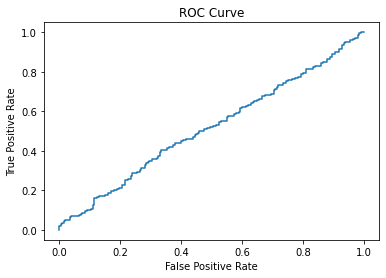

In [27]:
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()


In [33]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 400 images belonging to 2 classes.


array([0.38878807, 0.61393905, 0.47326997, 0.6033032 , 0.63055265,
       0.3805096 , 0.61542225, 0.38788208, 0.19061401, 0.2527479 ,
       0.37334254, 0.04026881, 0.6024777 , 0.3973044 , 0.7155678 ,
       0.22239019, 0.55263275, 0.5365569 , 0.5782575 , 0.61683863,
       0.28435722, 0.01844803, 0.67221004, 0.06419393, 0.06882203,
       0.48854104, 0.03833142, 0.45301768, 0.6896933 , 0.29174897,
       0.42435113, 0.12805521, 0.516277  , 0.18997377, 0.30177966,
       0.04114218, 0.5419538 , 0.6204424 , 0.23988199, 0.7121809 ,
       0.5000024 , 0.3839151 , 0.14620282, 0.5608799 , 0.28680176,
       0.06739844, 0.6531594 , 0.55345273, 0.2344726 , 0.09204745,
       0.616011  , 0.35983387, 0.6347036 , 0.5092945 , 0.25554913,
       0.43439198, 0.19954129, 0.28460354, 0.5765505 , 0.64645857,
       0.61860013, 0.0549806 , 0.08238063, 0.62631494, 0.74086976,
       0.60201627, 0.22694121, 0.3354967 , 0.7263137 , 0.5289214 ,
       0.68723756, 0.7319653 , 0.58601606, 0.2526386 , 0.10463

In [34]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.388788,0
1,0.613939,1
2,0.473270,0
3,0.603303,1
4,0.630553,1
...,...,...
395,0.654939,1
396,0.567660,1
397,0.751485,1
398,0.702490,1


In [35]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [36]:
y_pred = predictions['class'].values
y_pred

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [37]:
test_generator.class_indices

{'ben_mal': 0, 'nor': 1}

In [38]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[112,  88],
       [ 17, 183]])

In [39]:
model.evaluate(test_generator)

400/400 [==============================] - 2s 6ms/step - loss: 0.5354 - accuracy: 0.7375


[0.5354428291320801, 0.737500011920929]

In [40]:

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
preds = model.predict(test_generator, verbose = 1)

400/400 [==============================] - 1s 2ms/step


In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, _ = roc_curve(test_generator.classes, preds)


roc_auc = auc(fpr,tpr)

In [42]:
print('AUC:', roc_auc )

AUC: 0.8078


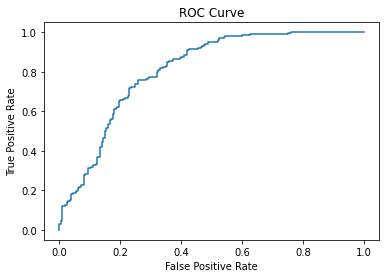

In [43]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()